In [ ]:
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import keras.utils as image
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

In [2]:
# Define directories
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'

# Image size
image_size = (224, 224, 3)

In [3]:

# Load images
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)


In [4]:
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [ ]:
# Load MobileNetV1 model
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)

# Create the model
mobilenet_with_gap = Model(inputs=base_mobilenet.input, outputs=x)

In [6]:
# Extract features using MobileNetV1
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [7]:
# Extract features using MobileNetV1
batch_size = 8
train_features = extract_features(mobilenet_with_gap, train_images, batch_size)
test_features = extract_features(mobilenet_with_gap, test_images, batch_size)

1/1 [==============================] - 0s 116ms/step


In [8]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10]
}

# Create Random Forest classifier
rf_classifier = RandomForestClassifier()

# Use GridSearchCV to find the best parameters for Random Forest
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(train_features, train_labels)

# Get the best parameters for Random Forest
best_rf_params = rf_grid_search.best_params_

# Train the final Random Forest model with the best parameters
final_rf_classifier = RandomForestClassifier(**best_rf_params)
start_time_rf = time.time()
final_rf_classifier.fit(train_features, train_labels)
train_time_rf = time.time() - start_time_rf

# Predict labels for the test set using Random Forest
rf_predictions = final_rf_classifier.predict(test_features)

# Evaluate accuracy for Random Forest
rf_accuracy = accuracy_score(test_labels, rf_predictions)
print("\nBest Random Forest Parameters:", best_rf_params)
print("Random Forest Accuracy:", rf_accuracy)



Best Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 500}
Random Forest Accuracy: 0.9864158829676071


In [9]:
# Additional evaluation metrics for Random Forest
precision_rf = precision_score(test_labels, rf_predictions, average='weighted')
recall_rf = recall_score(test_labels, rf_predictions, average='weighted')
f1_rf = f1_score(test_labels, rf_predictions, average='weighted')

print("Train Time (sec) Random Forest:", train_time_rf)
grid_train_time_rf = rf_grid_search.cv_results_['mean_fit_time'][rf_grid_search.best_index_]
print("Train Time (sec) Grid Random Forest:", grid_train_time_rf)

# Calculate Matthews Correlation Coefficient (MCC) for Random Forest
mcc_rf = matthews_corrcoef(test_labels, rf_predictions)
print("Matthews Correlation Coefficient (MCC) Random Forest:", mcc_rf)


Train Time (sec) Random Forest: 133.9498689174652
Train Time (sec) Grid Random Forest: 133.75059739748636
Matthews Correlation Coefficient (MCC) Random Forest: 0.9841832231452395


In [10]:

# Confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(test_labels, rf_predictions)
precision_rf = precision_score(test_labels, rf_predictions, average='weighted')

FP_rf = conf_matrix_rf.sum(axis=0) - np.diag(conf_matrix_rf)
FN_rf = conf_matrix_rf.sum(axis=1) - np.diag(conf_matrix_rf)
TP_rf = np.diag(conf_matrix_rf)
TN_rf = conf_matrix_rf.sum()


In [11]:
# Display results for Random Forest
print("\nResults for Random Forest:")
print("Precision (Random Forest):", precision_rf)
print("Recall (Random Forest):", recall_rf)
print("F1 Score (Random Forest):", f1_rf)
print("True Positive Rate (TPR) (Random Forest):", np.mean(TP_rf / (TP_rf + FN_rf)))
print("True Negative Rate (TNR) (Random Forest):", np.mean(TN_rf / (TN_rf + FP_rf)))
print("False Positive Rate (FPR) (Random Forest):", np.mean(FP_rf / (FP_rf + TN_rf)))
print("False Negative Rate (FNR) (Random Forest):", np.mean(FN_rf / (TP_rf + FN_rf)))
print("False Discovery Rate (FDR) (Random Forest):", np.mean(FP_rf / (FP_rf + TP_rf)))
print("False Omission Rate (FOR) (Random Forest):", np.mean(FN_rf / (FN_rf + TN_rf)))
print("Matthews Correlation Coefficient (MCC) (Random Forest):", mcc_rf)



Results for Random Forest:
Precision (Random Forest): 0.9865676024505702
Recall (Random Forest): 0.9864158829676071
F1 Score (Random Forest): 0.986255379630557
True Positive Rate (TPR) (Random Forest): 0.9673457173457174
True Negative Rate (TNR) (Random Forest): 0.9994583328809375
False Positive Rate (FPR) (Random Forest): 0.0005416671190625862
False Negative Rate (FNR) (Random Forest): 0.03265428265428265
False Discovery Rate (FDR) (Random Forest): 0.028064232064232062
False Omission Rate (FOR) (Random Forest): 0.0005416676621642179
Matthews Correlation Coefficient (MCC) (Random Forest): 0.9841832231452395


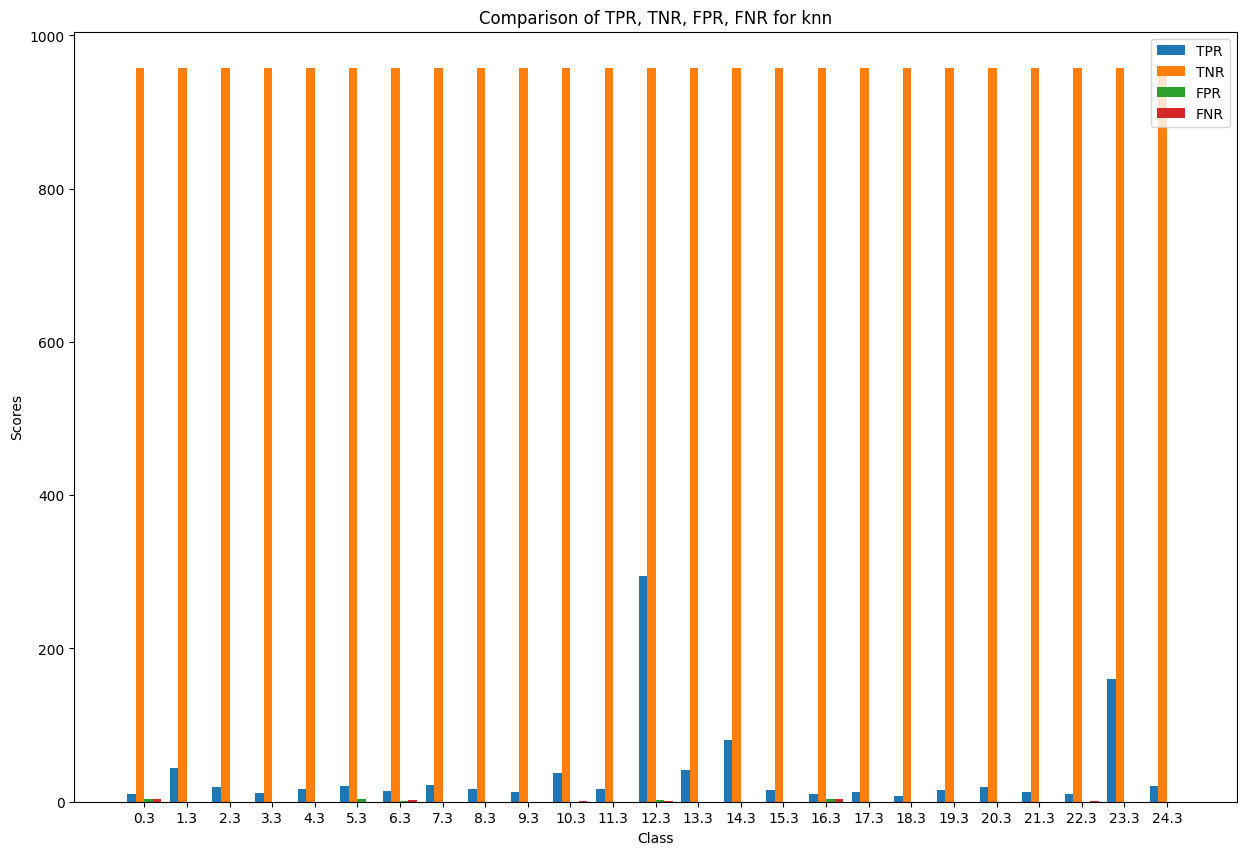

In [12]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP_rf, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_rf, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_rf, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_rf, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for knn')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

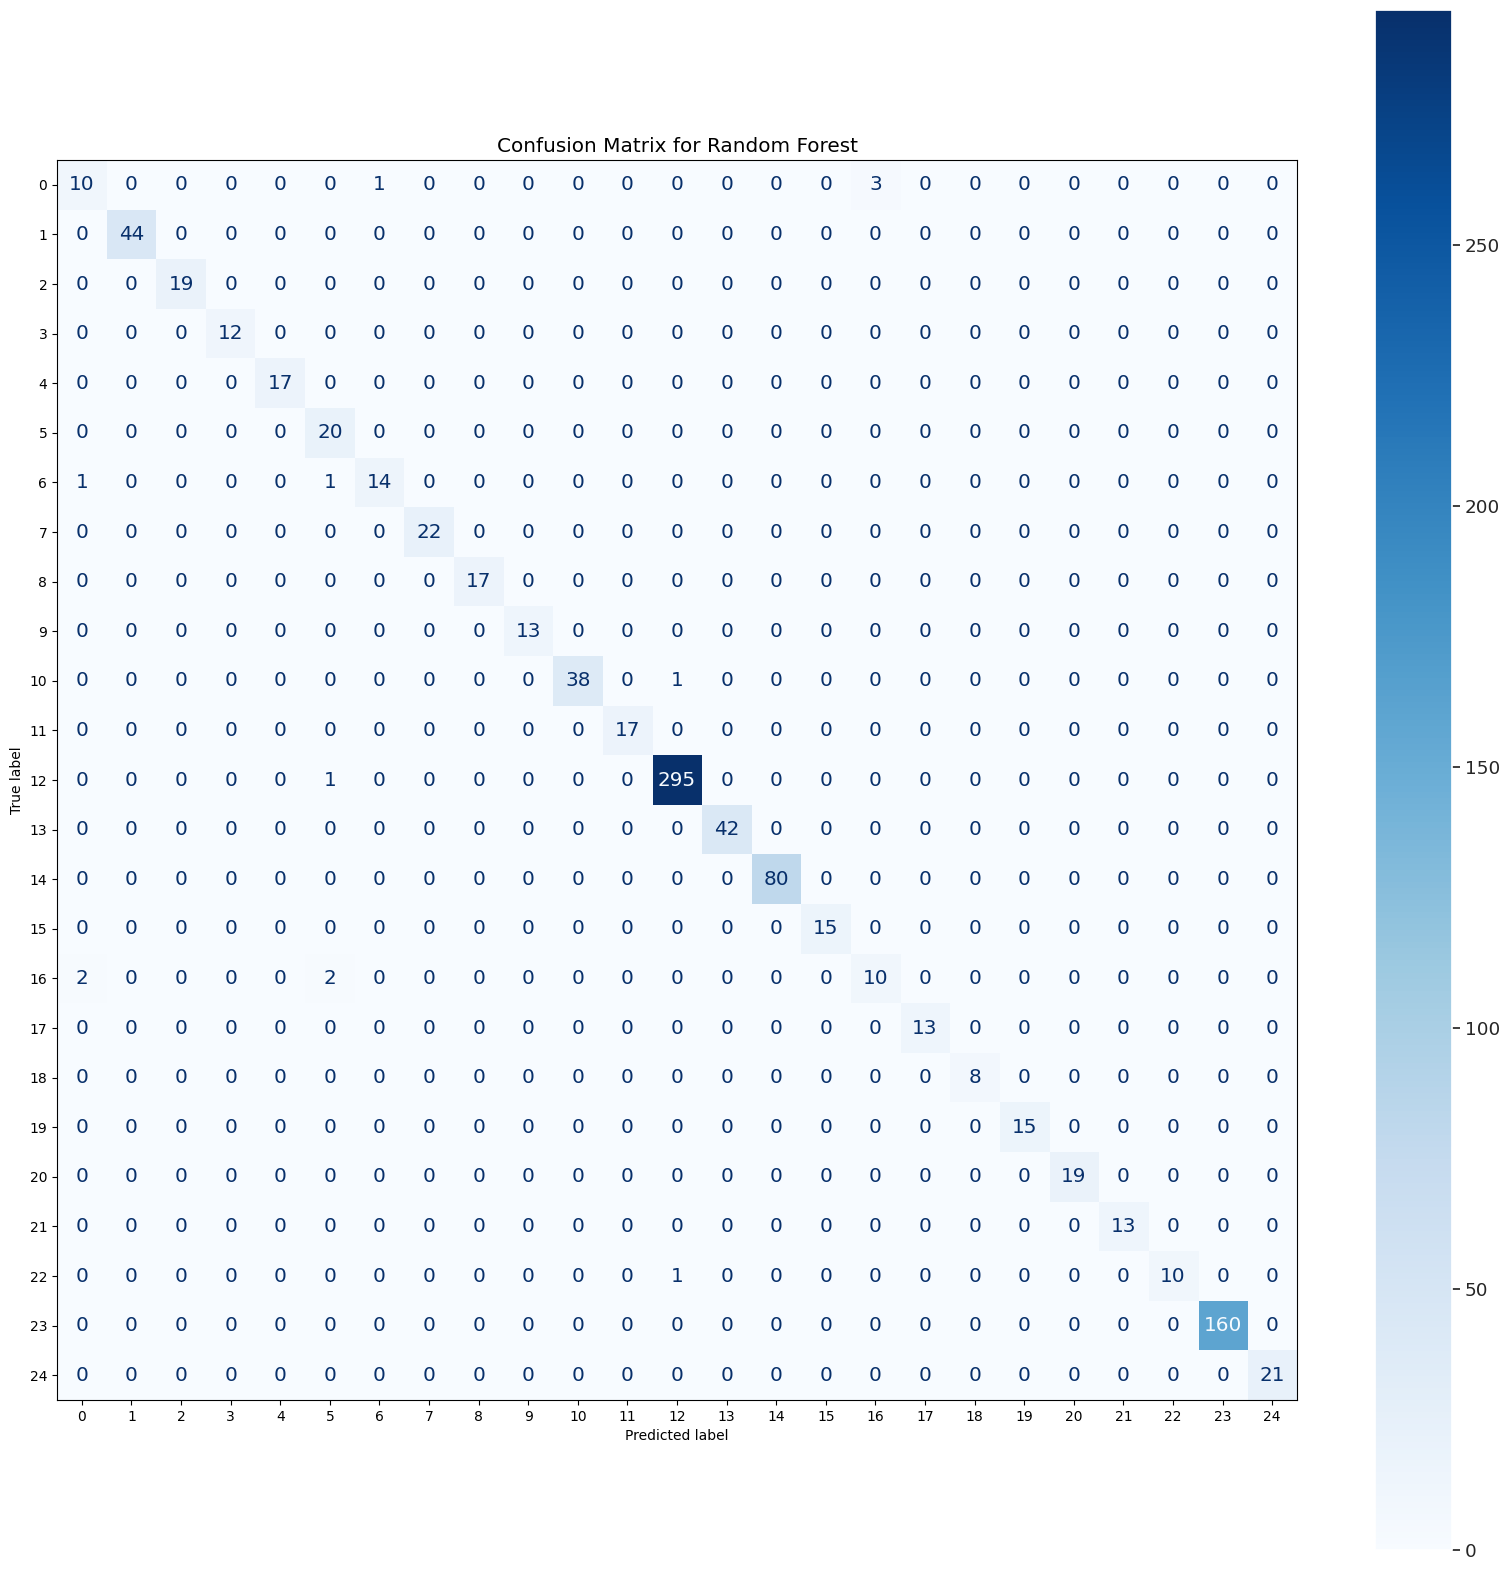

In [13]:
# Plot Confusion Matrix for Random Forest
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Random Forest')
plt.show()